 ## <b>Connecting vxi11 compatible devices via Ethernet </b>

In [10]:
!pip3 install python-vxi11

In [39]:
import vxi11
import time

In [40]:
keysight_ip = '192.168.0.8'

In [41]:
Keysight = vxi11.Instrument(keysight_ip)
print(Keysight.ask("*IDN?"))

Agilent Technologies,33512B,MY57401183,4.00-1.19-2.00-58-00


In [42]:
rigol_ip = '192.168.0.14'

In [43]:
Rigol = vxi11.Instrument(rigol_ip)
print(Rigol.ask("*IDN?"))

RIGOL TECHNOLOGIES,DS1074Z,DS1ZA193816619,00.04.04.SP3


## <b> Interacting with a Brüel & Kjær Type 3050-B-6 using Python </b>

In [ ]:
cd ../PyBnK

In [ ]:
from bnk.bnk import WavHeader, OpenWav, Instrument

In [ ]:
bnk_ip = '192.168.0.9'
ADAC = Instrument(bnk_ip)
print(ADAC) # Show some info about the BnK device

## <b> Python Wrapper for Keysight 33500B - Modified from Carlin's code</b>

In [44]:
class keysight():
    
    def __init__(self,instrument_ID=keysight_ip):
        self.Keysight =  vxi11.Instrument(instrument_ID)
        print(self.Keysight.ask("*IDN?"))
        
    def enable(self):
        self.Keysight.write("OUTPut ON")
        
    def disable(self):
        self.Keysight.write("OUTPut OFF") 
        
    def enable_high_impedance(self):
        self.Keysight.write("OUTPut:LOAD INF")  
        
    def sine(self,frequency=500,amplitude=0.01,offset=0):
        self.Keysight.write(f"VOLTage:OFFSet {offset}")
        self.Keysight.write("VOLTage:UNIT VRMS")
        self.Keysight.write(f"VOLTage {amplitude}")
        self.Keysight.write("FUNCtion SINusoid")
        self.Keysight.write(f"FREQuency {frequency}")
        
    def whitenoise(self, bandwidth=1500, amplitude=0.01):
        self.Keysight.write("VOLTage:UNIT VRMS")
        self.Keysight.write(f"VOLTage {amplitude}")
        self.Keysight.write("FUNCtion NOISe")
        self.Keysight.write(f"FUNCtion:NOISe:BANDwidth {bandwidth}")
        
    def enable_burst(self,frequency=2000,ncycles=50,int_period=5):
        self.Keysight.write("FUNCtion SINusoid")
        self.Keysight.write("BURSt:STATe ON")
        self.Keysight.write(f"FREQuency {frequency}")
        self.Keysight.write(f"BURSt:NCYCles {ncycles}")
        self.Keysight.write(f"BURSt:INTernal:PERiod {int_period}")          
        self.Keysight.write("OUTPut ON")
        
    def disable_burst(self):
        self.Keysight.write("BURSt:STATe OFF")
        self.Keysight.write("OUTPut OFF")
        
    def enable_sweep(self, mode="logarithmic", runTime=10):
        self.Keysight.write("FUNCtion SINusoid")
        self.Keysight.write("SWEep:STATe ON")
        self.Keysight.write(f"SWEep:SPAcing {mode}")
        self.Keysight.write(f"SWEep:TIME {runTime}")
        self.Keysight.write(f"FREQuency:STARt {10}")
        self.Keysight.write(f"FREQuency:STOP {20000}")
        self.Keysight.write("OUTPut ON")
        
    def disable_sweep(self):
        self.Keysight.write("SWEep:STATe OFF")
        self.Keysight.write("OUTPut OFF")

## <b> Connecting to RPI Zero W </b>

In [45]:
#Connecting to the RPi over Wi-Fi
import datetime
from paramiko import SSHClient
from scp import SCPClient
RPi = '192.168.0.6' # This is the IP address when RPi is connected to SHL network, note that this changes depending on different networks unless static IP is set
ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect(RPi,username='pi')

In [46]:
scp = SCPClient(ssh.get_transport())

In [52]:
# File directory for all audio .wav test files
cd ../Audio Files

SyntaxError: invalid syntax (<ipython-input-52-3279e0e7b756>, line 2)

In [51]:
# Checking Current File directory

import os
print(os.getcwd())
#scp.get('test_file.txt')

C:\Users\ricky\Documents\VM3000-Microphones\Audio Files


In [53]:
# Checking RPI Zero W files using ls

stdin, stdout, stderr = ssh.exec_command('ls -l')
for x in stdout: # stdout is a file, therefore to see the ls contents of the RPI, we use a for loop and print out all lines in stdout
    print(x)

total 556796

-rw-r--r--  1 pi   pi     2704044 Sep  7 09:28 48000

-rw-r--r--  1 pi   pi          44 Mar  3 13:57 ambientTest_20210312_104319.wav

-rw-r--r--  1 pi   pi         370 Sep 22 10:40 blinkatest.py

-rw-r--r--  1 pi   pi      960044 Mar  3 13:09 burstTest_20210312_094957.wav

-rw-r--r--  1 pi   pi      960044 Mar  3 13:09 burstTest_20210312_095048.wav

-rw-r--r--  1 pi   pi       24044 Mar  3 13:53 burstTest_20210312_103945.wav

-rw-r--r--  1 pi   pi          44 Mar  3 13:55 burstTest_20210312_104154.wav

-rw-r--r--  1 pi   pi     1920044 Mar  3 16:56 burstTest_20210312_134221.wav

-rw-r--r--  1 pi   pi     1920044 Mar  3 17:01 burstTest_20210312_134736.wav

-rwxr-xr-x  1 pi   pi        2677 Aug 26  2020 i2smic.sh

lrwxrwxrwx  1 pi   pi          55 Sep 23 02:54 linux -> /home/pi/linux-988cc7beacc150756c3fbe40646afcf8438b741b

drwxr-xr-x 27 pi   pi        4096 Sep 22 16:18 linux-43857965e5f526b9df807e543102a11fac1c0bcc

-rw-r--r--  1 pi   pi   163445874 Sep 22 16:13 linux-438

In [27]:
# client = SSHClient()
# client.load_system_host_keys()
# client.connect('192.168.0.6',username='pi')
#stdin, stdout, stderr = client.exec_command('touch test_file.txt')
#print(stdin)

In [37]:
# cmd = client.exec_command('arecord -D plughw:1 -c2 -r 48000 -f S16_LE -t wav -V stereo -v -d 50 tester2.wav')

In [41]:
# int(client.exec_command('ps -C arecord | wc -l')[1].read())

1

## <b> Class for Test Functions </b>

In [66]:
class signalTests():    
    def sweepTest(self, mode="logarithmic", recordTime=15, runTime=10, sleepTime=5):
        from paramiko import SSHClient
        from scp import SCPClient
        import datetime
        import time
        
        now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        sample_rate = 48000

        cmd = f'arecord -D plughw:1 -c2 -r {sample_rate} -f S16_LE -t wav -V stereo -v -d {recordTime} sweepTest_{now}.wav'

        print(cmd)
        ssh.exec_command(cmd)
        
        time.sleep(2.5) # Buffer time prior to enabling signal generator
        
        testName = "Sweep Test"
        
        sg.enable_sweep(mode, runTime)
        sg.enable()
        time.sleep(runTime)
        sg.disable()
        time.sleep(sleepTime)
        sg.disable_sweep()
        
        print(f"Finished {testName} Output")
        
        while (int(ssh.exec_command('ps -C arecord | wc -l')[1].read()) > 1): # Checking for arecord to finish writing .wav file prior to pulling file using scp
            time.sleep(1)
        
        scp.get(f'sweepTest_{now}.wav') # Command pulls file into .../Audio Files folder
        
    def sineTest(self, frequency=2000, amplitude=0.01, offset=0, recordTime=15, runTime=10, sleepTime=5):
        from paramiko import SSHClient
        from scp import SCPClient
        import datetime

        now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        sample_rate = 48000

        cmd = f'arecord -D plughw:1 -c2 -r {sample_rate} -f S16_LE -t wav -V stereo -v -d {recordTime} sineTest_{now}.wav'

        print(cmd)
        ssh.exec_command(cmd)
        
        time.sleep(2.5)
        
        testName = "Sine Wave Test"
        
        sg.sine(frequency,amplitude,offset)
        sg.enable()
        time.sleep(runTime)
        sg.disable()
        time.sleep(sleepTime)

        print(f"Finished {testName} Output")
        
        while (int(ssh.exec_command('ps -C arecord | wc -l')[1].read()) > 1):
            time.sleep(1)
        
        scp.get(f'sineTest_{now}.wav')
        
    def whiteNoiseTest(self, bandwidth=500, amplitude=0.01, recordTime=15, runTime=10, sleepTime=2):
        from paramiko import SSHClient
        from scp import SCPClient
        import datetime

        now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        sample_rate = 48000

        cmd = f'arecord -D plughw:1 -c2 -r {sample_rate} -f S16_LE -t wav -V stereo -v -d {recordTime} whiteNoiseTest_{now}.wav'

        print(cmd)
        ssh.exec_command(cmd)      
        
        time.sleep(2.5)
        
        testName = "White Noise Test"
        
        sg.whitenoise(bandwidth,amplitude)
        sg.enable()
        time.sleep(runTime)
        sg.disable()
        time.sleep(sleepTime)

        print(f"Finished {testName} Output")
        
        while (int(ssh.exec_command('ps -C arecord | wc -l')[1].read()) > 1):
            time.sleep(1)
        
        scp.get(f'whiteNoiseTest_{now}.wav')
        
    def burstTest(self, frequency=2000, ncycles=10, interval=1):
        from paramiko import SSHClient
        from scp import SCPClient
        import datetime

        now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        sample_rate = 48000

        cmd = f'arecord -D plughw:1 -c2 -r {sample_rate} -f S16_LE -t wav -V stereo -v -d {runTime} burstTest_{now}.wav'

        print(cmd)
        ssh.exec_command(cmd)     
        
        time.sleep(2.5)
        
        testName = "Burst Test"

        sg.enable_burst(frequency,ncycles,interval)

        for i in range(0,ncycles,1):
            print(f'Pulse number {i+1}')
            Keysight.write(f"FREQuency {frequency}")
            sg.enable()
            time.sleep(interval)
            sg.disable()
            time.sleep(interval)

        print(f"Finished {testName} Output")  
        
        while (int(ssh.exec_command('ps -C arecord | wc -l')[1].read()) > 1):
            time.sleep(1)
        
        scp.get(f'burstTest_{now}.wav')
        
    def ambientTest(self):
        from paramiko import SSHClient
        from scp import SCPClient
        import datetime

        now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        sample_rate = 48000

        cmd = f'arecord -D plughw:1 -c2 -r {sample_rate} -f S16_LE -t wav -V stereo -v -d {runTime} ambientTest_{now}.wav'

        print(cmd)
        ssh.exec_command(cmd)   
        
        time.sleep(2.5)
        
        testName = "Ambient Test"
        
        print(f"Finished {testName} Output")
        
        while (int(ssh.exec_command('ps -C arecord | wc -l')[1].read()) > 1):
            time.sleep(1)
        
        scp.get(f'ambientTest_{now}.wav')

## <b> Test Cases </b>

In [29]:
sg=keysight()
sg.enable_high_impedance()

Agilent Technologies,33512B,MY57401183,4.00-1.19-2.00-58-00


In [12]:
import paramiko
import time
import datetime

In [31]:
# Sweep Test

test1_name = "Sweep Test"
mode = "logarithmic"
sweep_period = 10

sg.enable_sweep(mode,sweep_period)
sg.enable()
time.sleep(sweep_period)
sg.disable()
time.sleep(sweep_period)
sg.disable_sweep()

print(f"Finished {test1_name} Output")

Finished Sweep Test Output


In [13]:
# Continuous Sine Wave Test

test2_name = "Sine Wave Test"
frequency = 2000
amplitude = 0.01 # Vrms
offset = 0
sleep_time = 2

sg.sine(frequency,amplitude,offset)
sg.enable()
time.sleep(sleep_time)
sg.disable()
time.sleep(sleep_time)

print(f"Finished {test2_name} Output")

Finished Sine Wave Test Output


In [376]:
# White Noise Test

test3_name = "White Noise Test"
bandwidth = 500
amplitude = 0.01 # Vrms
sleep_time = 2

sg.whitenoise(bandwidth,amplitude)
sg.enable()
time.sleep(sleep_time)
sg.disable()s
time.sleep(sleep_time)

print(f"Finished {test3_name} Output")

Finished


In [85]:
# Burst Sweep Test

test4_name = "Burst Sweep Test"
frequency = 2000
ncycles = 10
int_period = 1
sleep_time = 2

sg.enable_burst(frequency,ncycles,int_period)
  
for f in range(2000,5000,1000):
    print(f'Pulsing at {f} Hz')
    Keysight.write(f"FREQuency {f}")
    sg.enable()
    time.sleep(sleep_time)
    sg.disable()
    time.sleep(sleep_time)

sg.disable_burst()
    
print(f"Finished {test4_name} Output")

Pulsing at 2000 Hz
Pulsing at 3000 Hz
Pulsing at 4000 Hz
Finished Burst Sweep Test Output


In [17]:
# Burst Test Constant Frequency

test5_name = "Constant Frequency Burst Test"
frequency = 2000
ncycles = 10
int_period = 1
sleep_time = 2

sg.enable_burst(frequency,ncycles,int_period)

for i in range(1,11,1):
    print(f'Pulse number {i}')
    Keysight.write(f"FREQuency {frequency}")
    sg.enable()
    time.sleep(sleep_time)
    sg.disable()
    time.sleep(sleep_time)
          
print(f"Finished {test5_name} Output")

Pulse number 1
Pulse number 2
Pulse number 3
Pulse number 4
Pulse number 5
Pulse number 6
Pulse number 7
Pulse number 8
Pulse number 9
Pulse number 10
Finished Constant Frequency Burst Test Output


## <b> Frequency Response Characteristics Testing Script </b>

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy.fftpack import fft,fftfreq

import IPython
import numpy as np
import soundfile

import datetime

st = signalTests()

### Frequency Sweep Test

In [75]:
# Running Frequency Sweep Test & recording audio from RPI Zero W 

mode="logarithmic"
runTime=10
sleepTime=2
recordTime=15 # Always specify a recordTime greater than runTime to build in a buffer at the end of audio recording

now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

st.sweepTest(mode,recordTime,runTime,sleepTime)

arecord -D plughw:1 -c2 -r 48000 -f S16_LE -t wav -V stereo -v -d 15 sweepTest_20210312_153137.wav
Finished Sweep Test Output


Text(0.5, 1.0, 'Sweep Test plot (Stereo)')

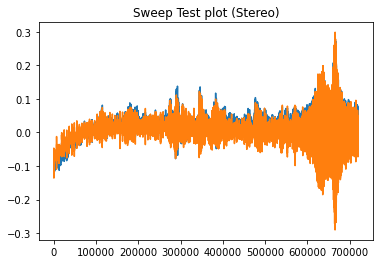

In [76]:
data, samplerate = soundfile.read(f"sweepTest_{now}.wav")
#data, samplerate = soundfile.read("sweepTest_20210312_152545.wav")

plt.plot(data[:recordTime*samplerate]) # Plotting stereo audio .wav file
plt.title("Sweep Test plot (Stereo)")

Text(0.5, 1.0, 'Sweep Test plot (Mono)')

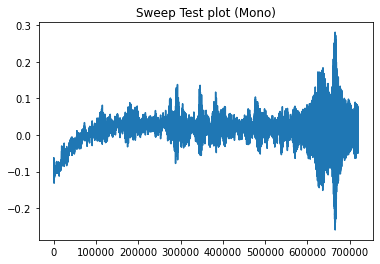

In [77]:
samples = data.shape[0]
data = data[:,0]

plt.plot(data[:recordTime*samplerate]) # Plotting mono audio .wav file
plt.title("Sweep Test plot (Mono)")

Text(0.5, 1.0, 'Sweep Test FFT Output plot (Mono)')

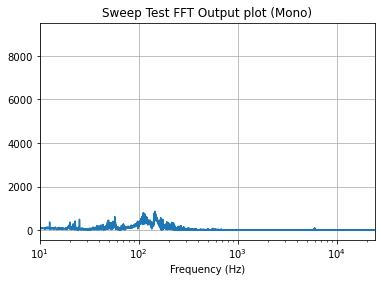

In [78]:
datafft = fft(data)
fftabs = abs(datafft)
freqs = fftfreq(samples,1/samplerate)

plt.xlim([10, samplerate/2])
plt.xscale( 'log' )
plt.grid( True )
plt.xlabel( 'Frequency (Hz)' )
plt.plot(freqs[:int(freqs.size/2)],fftabs[:int(freqs.size/2)]) # Plotting FFT output of mono wav file
plt.title("Sweep Test FFT Output plot (Mono)")

### Sine Wave Test

In [70]:
# Running Sine Wave Test & recording audio from RPI Zero W 

frequency=2000
amplitude=0.01 # Vrms
offset=0
runTime=10
sleepTime=2
recordTime=15

now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

st.sineTest(frequency,amplitude,offset,recordTime,runTime,sleepTime)

arecord -D plughw:1 -c2 -r 48000 -f S16_LE -t wav -V stereo -v -d 15 sineTest_20210312_153005.wav
Finished Sine Wave Test Output


In [84]:
data, samplerate = soundfile.read(f"sineTest_{now}.wav")
#data, samplerate = soundfile.read("sineTest_20210312_134022.wav")

plt.plot(data[:recordTime*samplerate]) # Plotting stereo audio
plt.title(f"Sine Wave Test plot at {frequency} Hz (Stereo)")

RuntimeError: Error opening 'sineTest_20210312_153406.wav': System error.

Text(0.5, 1.0, 'Sine Wave Test plot at 2000 Hz (Mono)')

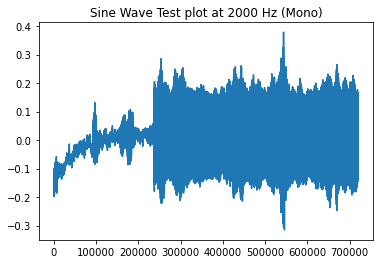

In [72]:
samples = data.shape[0]
data = data[:,0]

plt.plot(data[:recordTime*samplerate]) # Plotting mono audio
plt.title(f"Sine Wave Test plot at {frequency} Hz (Mono)")

Text(0.5, 1.0, 'Sine Wave Test FFT Output plot at 2000 Hz')

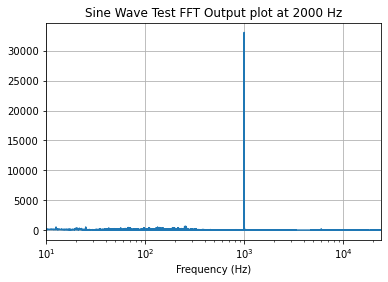

In [73]:
datafft = fft(data)
fftabs = abs(datafft)
freqs = fftfreq(samples,1/samplerate)
plt.xlim([10, samplerate/2])
plt.xscale( 'linear' )
plt.grid( True )
plt.xlabel( 'Frequency (Hz)' )
plt.plot(freqs[:int(freqs.size/2)],fftabs[:int(freqs.size/2)])
plt.title(f"Sine Wave Test FFT Output plot at {frequency} Hz")

### White Noise Test

In [79]:
# Running White Noise Test & recording audio from RPI Zero W

bandwidth=500
amplitude=0.01 # Vrms
runTime=10
sleepTime=2
recordTime=15

now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

st.whiteNoiseTest(bandwidth,amplitude,recordTime,runTime,sleepTime)

arecord -D plughw:1 -c2 -r 48000 -f S16_LE -t wav -V stereo -v -d 15 whiteNoiseTest_20210312_153252.wav
Finished White Noise Test Output


Text(0.5, 1.0, 'White Noise Test plot (Stereo)')

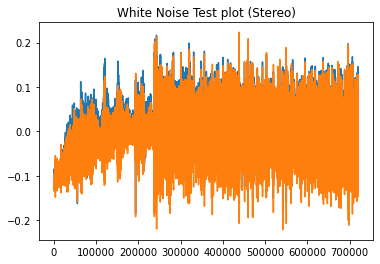

In [80]:
data, samplerate = soundfile.read(f"whiteNoiseTest_{now}.wav")
#data, samplerate = soundfile.read("whiteNoiseTest_20210312_134138.wav")

plt.plot(data[:recordTime*samplerate]) # Plotting stereo audio
plt.title("White Noise Test plot (Stereo)")

Text(0.5, 1.0, 'White Noise Test plot (Mono)')

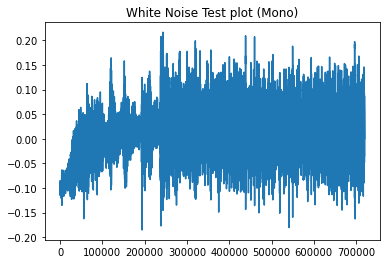

In [81]:
samples = data.shape[0]
data = data[:,0]

plt.plot(data[:recordTime*samplerate]) # Plotting mono audio
plt.title("White Noise Test plot (Mono)")

Text(0.5, 1.0, 'White Noise Test FFT Output plot')

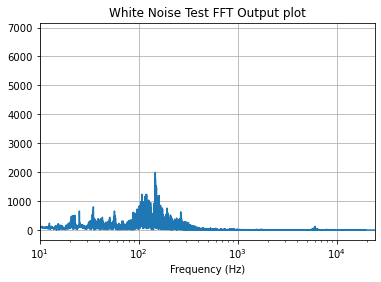

In [82]:
datafft = fft(data)
fftabs = abs(datafft)
freqs = fftfreq(samples,1/samplerate)
plt.xlim([10, samplerate/2])
plt.xscale( 'log' )
plt.grid( True )
plt.xlabel( 'Frequency (Hz)' )
plt.plot(freqs[:int(freqs.size/2)],fftabs[:int(freqs.size/2)])
plt.title("White Noise Test FFT Output plot")

### Burst Test

In [83]:
# Running Burst Test & recording audio from RPI Zero W

frequency=2000
ncycles=5
interval=1

now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

st.burstTest(frequency,ncycles,interval)

arecord -D plughw:1 -c2 -r 48000 -f S16_LE -t wav -V stereo -v -d 10 burstTest_20210312_153406.wav
Pulse number 0
Pulse number 1
Pulse number 2
Pulse number 3
Pulse number 4
Finished Burst Test Output


Text(0.5, 1.0, 'Burst Test plot (Stereo)')

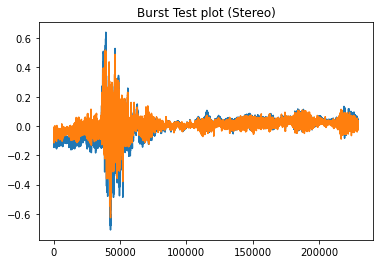

In [12]:
# data, samplerate = soundfile.read(f"burstTest_{now}.wav")
data, samplerate = soundfile.read("burstTest_20210312_134736.wav")

plt.plot(data[:recordTime*samplerate]) # Plotting stereo audio
plt.title("Burst Test plot (Stereo)")

Text(0.5, 1.0, 'Burst Test plot (Mono)')

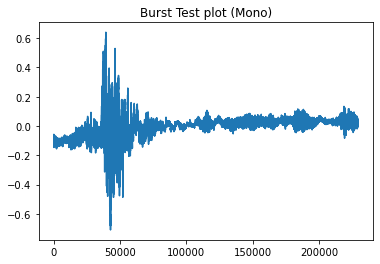

In [13]:
samples = data.shape[0]
data = data[:,0]

plt.plot(data[:recordTime*samplerate]) # Plotting mono audio
plt.title("Burst Test plot (Mono)")

Text(0.5, 1.0, 'Burst Test FFT Output plot')

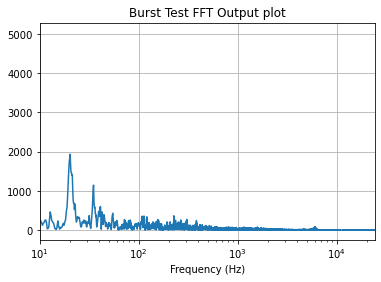

In [14]:
datafft = fft(data)
fftabs = abs(datafft)
freqs = fftfreq(samples,1/samplerate)
plt.xlim([10, samplerate/2])
plt.xscale( 'log' )
plt.grid( True )
plt.xlabel( 'Frequency (Hz)' )
plt.plot(freqs[:int(freqs.size/2)],fftabs[:int(freqs.size/2)])
plt.title("Burst Test FFT Output plot")

### Ambient Noise Test

In [22]:
# Running Ambient Noise Test & recording audio from RPI Zero W

now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

st.ambientTest()

arecord -D plughw:1 -c2 -r 48000 -f S16_LE -t wav -V stereo -v -d 5 ambientTest_20210312_104319.wav
Finished Ambient Test Output


In [ ]:
# data, samplerate = soundfile.read(f"ambientTest_{now}.wav")
data, samplerate = soundfile.read("ambientTest_20210312_104319.wav")

plt.plot(data[:recordTime*samplerate]) # Plotting stereo audio
plt.title("Burst Test plot (Stereo)")

In [ ]:
samples = data.shape[0]
data = data[:,0]

plt.plot(data[:recordTime*samplerate]) # Plotting mono audio
plt.title("Burst Test plot (Mono)")

In [ ]:
datafft = fft(data)
fftabs = abs(datafft)
freqs = fftfreq(samples,1/samplerate)
plt.xlim([10, samplerate/2])
plt.xscale( 'log' )
plt.grid( True )
plt.xlabel( 'Frequency (Hz)' )
plt.plot(freqs[:int(freqs.size/2)],fftabs[:int(freqs.size/2)])
plt.title("Burst Test FFT Output plot")